# Explainable Outcome Prediction - Experiments

- Author: David Steiner
- Last updated: December 2021

In [1]:
from prep_custom import get_dataset_settings,create_trace_bucket,remove_features,remove_events,split_data_temporal,replace_missing_cols,prepare_ml_train_test, aggregate_data
from prep_custom import scale_data, one_hot_encode, group_infrequent_features, prepare_dl_train_test, define_binary_outcome_label
from pred_custom import get_evaluation_metrics, train_model, plot_train_history, get_cnn_clf, get_lstm_clf, get_gru_clf, get_dnn_clf

import pandas as pd
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 100)

import numpy as np
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

## Load Dataset And Define Binary Outcome Goal

- BPIC17-LoanAccepted
- BPIC17-PotentialFraud
- BPIC17-LongRunningCases

- BPIC13-SupportLevel

- BPIC19-DeletedPO
- BPIC19-LongRunningCases

- BPICHospital-BillingClosed
- BPICHospital-CaseReopened

In [3]:
#Load Dataset 
data, case_id_col, activity_col, timestamp_col, label_col, resource_col, event_categorical_attributes, event_numeric_attributes, case_categorical_attributes, case_numeric_attributes, static_cols, dynamic_cols, cat_cols = get_dataset_settings("BPIC17")
attributes = [event_categorical_attributes, case_categorical_attributes, event_numeric_attributes, case_numeric_attributes]

Categoric Event Attributes: 6 ['concept:name', 'org:resource', 'Action', 'lifecycle:transition', 'Accepted', 'Selected'] 

Numeric Event Attributes: 13 ['CreditScore', 'FirstWithdrawalAmount', 'MonthlyCost', 'NumberOfTerms', 'OfferedAmount', 'timesincelastevent', 'timesincecasestart', 'timesincemidnight', 'event_nr', 'month', 'weekday', 'hour', 'open_cases'] 

Categoric Case Attributes: 3 ['case:ApplicationType', 'case:LoanGoal', 'EventOrigin'] 

Numeric Case Attributes: 1 ['case:RequestedAmount'] 

Dataset Shape (1202267, 26)


In [27]:
#Select Outcome and apply labelling function
data_labeled, drop_events_list, dl_attributes = define_binary_outcome_label(data, attributes, outcome_label='BPIC17-LoanAccepted')

Assigning class labels...
Set labels to 1 for Outcome: O_Accepted
label
0    18621
1    12792
Name: case:concept:name, dtype: int64


In [28]:
data_labeled

,case:ApplicationType,case:LoanGoal,case:RequestedAmount,case:concept:name,label,concept:name,org:resource,Action,CreditScore,EventOrigin,lifecycle:transition,Accepted,Selected,FirstWithdrawalAmount,MonthlyCost,NumberOfTerms,OfferedAmount,timesincelastevent,timesincecasestart,timesincemidnight,event_nr,month,weekday,hour,open_cases,time:timestamp,last_o_activity
0,New credit,"Other, see explanation",5000.0,Application_1000086665,0,A_Create Application,User_1,Created,-5.0,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.000000,0.000000,957,1,8,2,15,2250,2016-08-03 15:57:21.673000+00:00,O_Cancelled
1,New credit,"Other, see explanation",5000.0,Application_1000086665,0,A_Submitted,User_1,statechange,-5.0,Application,complete,missing,missing,0.0,0.00,0.0,0.0,0.001017,0.001017,957,2,8,2,15,2250,2016-08-03 15:57:21.734000+00:00,O_Cancelled
2,New credit,"Other, see explanation",5000.0,Application_1000086665,0,W_Handle leads,User_1,Created,-5.0,Workflow,schedule,missing,missing,0.0,0.00,0.0,0.0,0.003817,0.004833,957,3,8,2,15,2250,2016-08-03 15:57:21.963000+00:00,O_Cancelled
3,New credit,"Other, see explanation",5000.0,Application_1000086665,0,W_Handle leads,User_1,Deleted,-5.0,Workflow,withdraw,missing,missing,0.0,0.00,0.0,0.0,1.105383,1.110217,958,4,8,2,15,2250,2016-08-03 15:58:28.286000+00:00,O_Cancelled
4,New credit,"Other, see explanation",5000.0,Application_1000086665,0,W_Complete application,User_1,Created,-5.0,Workflow,schedule,missing,missing,0.0,0.00,0.0,0.0,0.000117,1.110333,958,5,8,2,15,2250,2016-08-03 15:58:28.293000+00:00,O_Cancelled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1070974,New credit,Caravan / Camper,30000.0,Application_999993812,1,W_Call incomplete files,Other_infrequent,Obtained,877.0,Workflow,start,True,True,30000.0,349.13,102.0,30000.0,0.000033,18647.419867,764,28,10,2,12,2320,2016-10-19 12:44:29.291000+00:00,O_Accepted
1070975,New credit,Caravan / Camper,30000.0,Application_999993812,1,A_Incomplete,Other_infrequent,statechange,877.0,Application,complete,True,True,30000.0,349.13,102.0,30000.0,0.000017,18647.419883,764,29,10,2,12,2320,2016-10-19 12:44:29.292000+00:00,O_Accepted
1070976,New credit,Caravan / Camper,30000.0,Application_999993812,1,W_Call incomplete files,Other_infrequent,Released,877.0,Workflow,suspend,True,True,30000.0,349.13,102.0,30000.0,0.097367,18647.517250,764,30,10,2,12,2320,2016-10-19 12:44:35.134000+00:00,O_Accepted
1070977,New credit,Caravan / Camper,30000.0,Application_999993812,1,W_Call incomplete files,Other_infrequent,Obtained,877.0,Workflow,resume,True,True,30000.0,349.13,102.0,30000.0,1174.894633,19822.411883,499,31,10,3,8,2320,2016-10-20 08:19:28.812000+00:00,O_Accepted


In [29]:
dl_attributes

[['concept:name', 'org:resource', 'Action', 'lifecycle:transition'],
 ['case:ApplicationType', 'case:LoanGoal', 'EventOrigin'],
 ['CreditScore',
  'FirstWithdrawalAmount',
  'MonthlyCost',
  'NumberOfTerms',
  'OfferedAmount',
  'timesincelastevent',
  'timesincecasestart',
  'timesincemidnight',
  'event_nr',
  'month',
  'weekday',
  'hour',
  'open_cases'],
 ['case:RequestedAmount']]

# Prediction Pipeline

### Bucket Traces And Remove Outcome Specific Events & Features

In [30]:
data_labeled_grouped = group_infrequent_features(data_labeled, max_category_levels = 15)
#trace_bucket = create_mixed_bucket(data_labeled_grouped, min_event_length=5, max_event_length=20)
trace_bucket = create_trace_bucket(data_labeled_grouped, 10) #select prefix length
trace_bucket = remove_features(trace_bucket, dl_attributes[0], dl_attributes[1], dl_attributes[2], dl_attributes[3])
trace_bucket = remove_events(data_labeled, trace_bucket, drop_events_list)

Binning and Grouping infrequent factor levels to: Other_infrequent
Making predictions after 10 completed events
Making predictions at time after cases have started on average:  26.7 hours/ 1.112 days
Making predictions at time before cases have finished on average:  450.0 hours/ 18.7 days

 Shape: (313787, 27)
Features removed:  3

 Events included:
['A_Create Application' 'A_Submitted' 'W_Handle leads'
 'W_Complete application' 'A_Concept' 'A_Accepted' 'O_Create Offer'
 'O_Created' 'O_Sent (mail and online)' 'W_Call after offers'
 'O_Sent (online only)' 'W_Assess potential fraud' 'A_Cancelled'
 'W_Shortened completion ' 'A_Denied']


### Train Test Split 

In [31]:
train_raw, test_raw = split_data_temporal(data=trace_bucket, train_ratio=0.8)

print(len(train_raw), 'train events')
print(len(test_raw), 'test events')
print(len(train_raw.groupby(case_id_col).count()), 'train cases')
print(len(test_raw.groupby(case_id_col).count()), 'test cases')

250531 train events
62753 test events
25130 train cases
6283 test cases


### Sequence Encoding

- One Hot Encoding for events and categorical features 
- Max aggregations for numerical features

In [32]:
#event_categorical_attributes, case_categorical_attributes, event_numeric_attributes, case_numeric_attributes
#dl_attributes

sequence_encoding_setting = dict(case_id_col=case_id_col, 
                          activity_col=activity_col,
                          label_col=label_col,
                          case_numeric_attributes=dl_attributes[3],
                          case_categorical_attributes=dl_attributes[1],
                          event_numeric_attributes=dl_attributes[2],
                          event_categorical_attributes=dl_attributes[0],
                            d_event_sequence = False,
                            d_event = True,
                            d_event_categorical = True,
                            d_case_categorical = True,
                            one_hot_case_categorical = True,   
                            d_event_numeric = True,
                            d_case_numeric = True)

In [33]:
train = aggregate_data(train_raw, 
                       **sequence_encoding_setting)

test = aggregate_data(test_raw, 
                       **sequence_encoding_setting)

In [34]:
train, test = replace_missing_cols(train, test)

[] []


# Classical Machine Learning Classifiers

In [35]:
X_train, y_train, X_test, y_test = prepare_ml_train_test(train,test, balanced=True)

Undersampling Train Data
(20546, 71) (6283, 71)


### Pred Mixed Bucket

In [36]:
"""
#Trace Bucket Test
ids = test_raw[case_id_col].unique()
tmp = data[data[case_id_col].isin(ids)]
trace_bucket_test = create_trace_bucket(tmp, 15)

test_bucket = aggregate_data(trace_bucket_test, 
                            **sequence_encoding_setting)

train, test = replace_missing_cols(train, test_bucket)

X_train, y_train, X_test, y_test = prepare_ml_train_test(train,test, balanced=False)

from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
get_evaluation_metrics(clf_rf, X_test, y_test, X_train, y_train)

from catboost import CatBoostClassifier
clf_cbc = CatBoostClassifier(silent=True)
clf_cbc.fit(X_train, y_train)
get_evaluation_metrics(clf_cbc, X_test, y_test, X_train, y_train)
"""

'\n#Trace Bucket Test\nids = test_raw[case_id_col].unique()\ntmp = data[data[case_id_col].isin(ids)]\ntrace_bucket_test = create_trace_bucket(tmp, 15)\n\ntest_bucket = aggregate_data(trace_bucket_test, \n                            **sequence_encoding_setting)\n\ntrain, test = replace_missing_cols(train, test_bucket)\n\nX_train, y_train, X_test, y_test = prepare_ml_train_test(train,test, balanced=False)\n\nfrom sklearn.ensemble import RandomForestClassifier\nclf_rf = RandomForestClassifier()\nclf_rf.fit(X_train, y_train)\nget_evaluation_metrics(clf_rf, X_test, y_test, X_train, y_train)\n\nfrom catboost import CatBoostClassifier\nclf_cbc = CatBoostClassifier(silent=True)\nclf_cbc.fit(X_train, y_train)\nget_evaluation_metrics(clf_cbc, X_test, y_test, X_train, y_train)\n'

In [37]:
#y_train = y_train.label.ravel()
#X_train = X_train.to_numpy()
#y_test = y_test.label.ravel()
#X_test = X_test.to_numpy()

### Logistic Regression

In [38]:
%%time
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression(random_state=0)
clf_lr.fit(X_train, y_train)
mertrics = get_evaluation_metrics(clf_lr, X_test, y_test, X_train, y_train)

Confusion Matrix:
[[3598  166]
 [1017 1502]]
              precision    recall  f1-score   support

           0       0.78      0.96      0.86      3764
           1       0.90      0.60      0.72      2519

    accuracy                           0.81      6283
   macro avg       0.84      0.78      0.79      6283
weighted avg       0.83      0.81      0.80      6283

Accuracy: 0.812 (Train: 0.768 )
AUC: 0.846
F1: 0.788
MCC: 0.613
Sensitivity :  0.956
Specificity :  0.596
Wall time: 480 ms


### Random Forest

In [39]:
%%time
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
mertrics = get_evaluation_metrics(clf_rf, X_test, y_test, X_train, y_train)

Confusion Matrix:
[[3189  575]
 [ 546 1973]]
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      3764
           1       0.77      0.78      0.78      2519

    accuracy                           0.82      6283
   macro avg       0.81      0.82      0.81      6283
weighted avg       0.82      0.82      0.82      6283

Accuracy: 0.822 (Train: 1.0 )
AUC: 0.907
F1: 0.815
MCC: 0.629
Sensitivity :  0.847
Specificity :  0.783
Wall time: 4.34 s


### XGBoost

In [40]:
%%time
import xgboost as xgb
clf_xgb = xgb.XGBClassifier()
clf_xgb.fit(X_train, y_train)
mertrics = get_evaluation_metrics(clf_xgb, X_test, y_test, X_train, y_train)

[11:45:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Confusion Matrix:
[[3398  366]
 [ 668 1851]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3764
           1       0.83      0.73      0.78      2519

    accuracy                           0.84      6283
   macro avg       0.84      0.82      0.82      6283
weighted avg       0.84      0.84      0.83      6283

Accuracy: 0.835 (Train: 0.904 )
AUC: 0.907
F1: 0.825
MCC: 0.654
Sensitivity :  0.903
Specificity :  0.735
Wall time: 3.27 s


### CatBoost

In [41]:
%%time
from catboost import CatBoostClassifier
clf_cbc = CatBoostClassifier(silent=True)
clf_cbc.fit(X_train, y_train)
mertrics = get_evaluation_metrics(clf_cbc, X_test, y_test, X_train, y_train)

Confusion Matrix:
[[3172  592]
 [ 508 2011]]
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3764
           1       0.77      0.80      0.79      2519

    accuracy                           0.82      6283
   macro avg       0.82      0.82      0.82      6283
weighted avg       0.83      0.82      0.83      6283

Accuracy: 0.825 (Train: 0.868 )
AUC: 0.913
F1: 0.819
MCC: 0.638
Sensitivity :  0.843
Specificity :  0.798
Wall time: 13.6 s


### ExplainableBoostingClassifier

In [42]:
%%time
from interpret.glassbox import ExplainableBoostingClassifier
clf_ebm = ExplainableBoostingClassifier()
clf_ebm.fit(X_train, y_train)
mertrics = get_evaluation_metrics(clf_ebm, X_test, y_test, X_train, y_train)

Confusion Matrix:
[[3390  374]
 [ 654 1865]]
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3764
           1       0.83      0.74      0.78      2519

    accuracy                           0.84      6283
   macro avg       0.84      0.82      0.83      6283
weighted avg       0.84      0.84      0.83      6283

Accuracy: 0.836 (Train: 0.823 )
AUC: 0.91
F1: 0.826
MCC: 0.656
Sensitivity :  0.901
Specificity :  0.74
Wall time: 1min 2s


## Deep Learning Classifiers

In [43]:
train, test = scale_data(train_raw, test_raw)
train = one_hot_encode(train)
test = one_hot_encode(test)
train, test = replace_missing_cols(train, test)

X_train_dl, y_train_dl, feature_names = prepare_dl_train_test(train, 5)
X_test_dl, y_test_dl, feature_names = prepare_dl_train_test(test, 5)

[] []


### CNN

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 5, 8)              10232     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 5, 4)              36        
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 4)              0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 2, 4)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               2304      
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0       

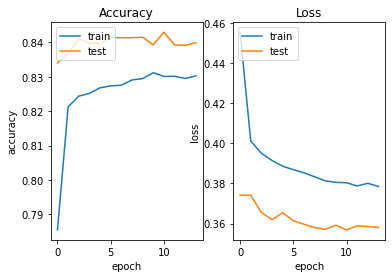

Wall time: 56.8 s


In [44]:
%%time
## DL Model Training and Evaluation
model_structure = get_cnn_clf(X_train_dl)

model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                    verbose=True, weighted=True, epochs=20, batch_size=32)

metrics = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl)
plot_train_history(hist)

### GRU

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 5, 480)            796320    
_________________________________________________________________
gru_4 (GRU)                  (None, 5, 448)            1249920   
_________________________________________________________________
gru_5 (GRU)                  (None, 96)                157248    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 97        
Total params: 2,203,585
Trainable params: 2,203,585
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.8457292858585179, 1: 1.2231091209967877}
Epoch 1/20
786/786 [==============================] - 60s 71ms/step - loss: 0.5641 - auc: 0.8060 - acc: 0.7603 - val_loss: 0.4373 - val_auc: 0.8890 - val_acc: 0.8214
Epoch 2/20
786/786 [=============

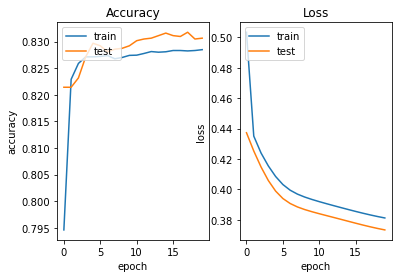

Wall time: 24min 31s


In [45]:
%%time
## DL Model Training and Evaluation
model_structure = get_gru_clf(X_train_dl)

model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                    verbose=True, weighted=True, epochs=20, batch_size=32)

metrics = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl)
plot_train_history(hist)

### LSTM

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 5, 352)            596992    
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 512)            1771520   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 2,696,833
Trainable params: 2,696,833
Non-trainable params: 0
_________________________________________________________________
None
{0: 0.8457292858585179, 1: 1.2231091209967877}
Epoch 1/20
786/786 [==============================] - 72s 87ms/step - loss: 0.6797 - auc: 0.6280 - acc: 0.6253 - val_loss: 0.6307 - val_auc: 0.7339 - val_acc: 0.7385
Epoch 2/20
786/786 [============

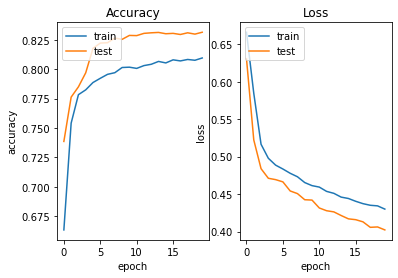

Wall time: 24min 47s


In [46]:
%%time
## DL Model Training and Evaluation
model_structure = get_lstm_clf(X_train_dl)

model, hist = train_model(model_structure, X_train_dl, X_test_dl, y_train_dl, y_test_dl, 
                    verbose=True, weighted=True, epochs=20, batch_size=32)

metrics = get_evaluation_metrics(model, X_test_dl, y_test_dl, X_train_dl, y_train_dl)
plot_train_history(hist)